In [ ]:
import pandas as pd
import re
import os
import numpy as np
import dlib
import cv2

#from torch.utils.data import Dataset, DataLoader
#from torchvision.datasets import ImageFolder
#from torchvision import transforms
#from PIL import Image
#import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import math

In [ ]:
# install dlib (will take 10 or more minutes)
!apt update
!apt install -y cmake
!pip install dlib

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:8 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,027 kB]
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:12 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,589 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK

!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2

datFile =  "/content/shape_predictor_68_face_landmarks.dat"

#dlib functionalities
hog_face_detector = dlib.get_frontal_face_detector()
dlib_facelandmark = dlib.shape_predictor(datFile)

--2023-03-31 08:43:05--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  14.5MB/s    in 9.0s    

2023-03-31 08:43:14 (6.76 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



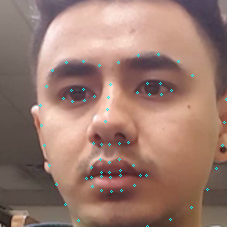

In [ ]:
#demo of dlib face landmark detection
from google.colab.patches import cv2_imshow

testimagepath = '/content/drive/MyDrive/newdata/Driver Drowsiness Dataset (DDD)/Non Drowsy/d0590.png'
testimage = cv2.imread(os.path.join(testimagepath),cv2.IMREAD_UNCHANGED)

faceList = hog_face_detector(testimage)
for singleFace in faceList:
  face_landmarks = dlib_facelandmark(testimage, singleFace)

  for n in range(0, 68):
    x = face_landmarks.part(n).x
    y = face_landmarks.part(n).y
    cv2.circle(testimage, (x, y), 1, (255, 255, 0), 1)
cv2_imshow(testimage)

# Neuer Abschnitt

In [ ]:
from scipy.spatial import distance

#calculate the eye aspect ratio
def calculate_EAR(eye):
  A = distance.euclidean(eye[1], eye[5])
  B = distance.euclidean(eye[2], eye[4])
  C = distance.euclidean(eye[0], eye[3])
  eye_aspect_ratio = (A+B)/(2.0*C)
  return eye_aspect_ratio


In [ ]:
def predictLabelWithEAR(dlib_facelandmark, faces, grayscale, predictions):
  #go through all faces that have been detected by the hog_face_detector
  for face in faces:
    face_landmarks = dlib_facelandmark(grayscale, face)
    leftEye = []
    rightEye = []

    #save landmarks of the eyes
    #leftEye
    for n in range(36, 42):
      x = face_landmarks.part(n).x
      y = face_landmarks.part(n).y
      #cv2.circle(image, (x, y), 1, (0, 0, 255), 1)
      leftEye.append((x,y))
    
    #rightEye
    for n in range(42, 48):
      x = face_landmarks.part(n).x
      y = face_landmarks.part(n).y
      #cv2.circle(image, (x, y), 1, (0, 255, 0), 1)
      rightEye.append((x,y))
    
    #claculate eye aspect ratio for every eye
    left_ear = calculate_EAR(leftEye)
    right_ear = calculate_EAR(rightEye)

    ear = (left_ear+right_ear)/2
    ear = round(ear, 2)

    #if eye aspect ratio is below a threshold - classify as drowsy
    if ear < 0.26:
      #drowsy
      predictions.append(0)
    else:
      #not drowsy
      predictions.append(1)

#cv2_imshow(image)

In [ ]:
# Add image paths, labels, file names and person IDs into lists
image_path, label, file_name, person_ID = [], [], [], []
#list of predicted labels by the eye aspect ratio
predictions = []

pattern = re.compile(r'^[a-zA-Z][a-zA-Z]?') #identification criteria of participant

data_dir = "/content/drive/MyDrive/newdata/Driver Drowsiness Dataset (DDD)/"
#data_dir = "/content/drive/MyDrive/smalltest/testDDD/"

for class_name in os.listdir(data_dir):  #goes through all folders in DDD folder
  for imageName in os.listdir(data_dir+class_name):  #goes through all files in both folders and updates file path and labels
    #correct label
    if class_name == 'Drowsy':
      label.append(0)
    else:
      label.append(1)
    #image path
    image_path.append(os.path.join(data_dir, class_name, imageName))
    #file name
    file_name.append(imageName)
    #personID
    person_ID.append(pattern.findall(imageName)[0])  #identification of participant

    #prediction of the label by landmark
    image = cv2.imread(os.path.join(data_dir, class_name, imageName),cv2.IMREAD_UNCHANGED)
    #grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = hog_face_detector(image)
    if len(faces)==0:
      #no face was detected
      predictions.append(-1)
    else:
      #face was detected - predict the label
      predictLabelWithEAR(dlib_facelandmark, faces, image, predictions)

#dataframe with path, label, predicted label, file name, person_ID of all Persons
df = pd.DataFrame()
df['images'] = image_path
df['label'] = label
df['predlabel'] = predictions
df['name'] = file_name
df['person'] = person_ID

print('df')
print(df)
print('df shape')
print(df.shape)

df
                                                  images  label  predlabel  \
0      /content/drive/MyDrive/newdata/Driver Drowsine...      1          0   
1      /content/drive/MyDrive/newdata/Driver Drowsine...      1          1   
2      /content/drive/MyDrive/newdata/Driver Drowsine...      1          1   
3      /content/drive/MyDrive/newdata/Driver Drowsine...      1          1   
4      /content/drive/MyDrive/newdata/Driver Drowsine...      1          1   
...                                                  ...    ...        ...   
41788  /content/drive/MyDrive/newdata/Driver Drowsine...      0          0   
41789  /content/drive/MyDrive/newdata/Driver Drowsine...      0          0   
41790  /content/drive/MyDrive/newdata/Driver Drowsine...      0          0   
41791  /content/drive/MyDrive/newdata/Driver Drowsine...      0          0   
41792  /content/drive/MyDrive/newdata/Driver Drowsine...      0          1   

             name person  
0      zc0353.png     zc  
1     

In [ ]:
#classiefied wrong by eye aspect ratio
notCorrectDf = df[df['label']!=df['predlabel']]
print('notCorrectDf')
print(notCorrectDf.shape)

#classified correctly by eye aspect ratio
CorrectDf = df[df['label']==df['predlabel']]
print('CorrectDf')
print(CorrectDf.shape)

notCorrectDf
(18851, 5)
CorrectDf
(22942, 5)


In [ ]:
notCorrectDf.groupby('person').size()

person
A      194
B      125
C      332
D       96
E      906
F      395
G       68
H      505
I      140
J       16
K      465
L      430
M      757
N      845
O      925
P      161
Q      116
R      166
S       79
T        8
U      404
V       54
W      973
X      270
Y       59
ZA      64
ZB     842
ZC    1327
a      284
b       50
c      345
d      138
e      218
g        8
h       67
i      945
j       77
k       33
l        1
m      432
n      851
o       93
p      187
q       50
r       40
s       31
u      195
v      662
w        6
x     1097
y      857
za    1030
zb     400
zc      32
dtype: int64

In [ ]:
#error face couldnt be detected
noFaceDetection = notCorrectDf[notCorrectDf['predlabel']==-1]
print('noFaceDetection')
print(noFaceDetection.shape)
print('-----')
noFaceDetection.groupby('person').size()

noFaceDetection
(5747, 5)
-----


person
B      83
C     101
D       3
E     753
G      68
H       5
I      20
J      15
M     757
N     838
O     302
P     149
R      24
S      37
T       3
U     334
V      10
W      28
X      10
Y       1
ZA     15
ZB    126
a      68
b      35
c     345
e     218
i     144
m     218
n     582
o      72
u     181
v      40
w       5
x      13
y     132
za      8
zb      4
dtype: int64

In [ ]:
#face detected but classified wrong
notCorrectDf[notCorrectDf['predlabel']!=-1].groupby('person').size()

person
A      194
B       42
C      231
D       93
E      153
F      395
H      500
I      120
J        1
K      465
L      430
N        7
O      623
P       12
Q      116
R      142
S       42
T        5
U       70
V       44
W      945
X      260
Y       58
ZA      49
ZB     716
ZC    1327
a      216
b       15
d      138
g        8
h       67
i      801
j       77
k       33
l        1
m      214
n      269
o       21
p      187
q       50
r       40
s       31
u       14
v      622
w        1
x     1084
y      725
za    1022
zb     396
zc      32
dtype: int64